<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M3_2_Transformermodels_NLU_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main questions that we aim to answer in this lecture are:

1. What are the main challenges of RNNs and LSTMs?
2. Attention Mechanisms
      - How do attention mechanisms solve the challenges associated with RNNs and LSTMs?
      - What is the fundamental idea behind the attention mechanism?
      - How does the attention mechanism function?
3. What is the Transformer model architecture, and how does it differ from encoder-decoder models?
4. What is text embedding?
5. How can one train a Transformer model to compute embeddings?
6. What are the differences between word embeddings and sentence embeddings?




## How Do Attention Mechanisms Solve RNN and LSTM Challenges?

![](https://miro.medium.com/v2/resize:fit:1280/1*w2OJ4jfjxmlcqu6k4BdgrA.gif)

| RNN/LSTM Problems                          | How Attention Helps                                   |
|--------------------------------------------|------------------------------------------------------|
| Hard to learn from long steps back         | Looks directly at important past information         |
| Training can be unstable                   | Uses special techniques to stay stable (gradient clipping or other techniques)               |
| Slow with long sentences                   | Works on whole sentences at once, so it's faster     |
| Struggles with very distant info           | Can easily use info from anywhere in the sentence    |
| Can't always use all relevant info         | Chooses which info to use at each step               |
| Can be heavy on memory                     | Lighter on memory, no need to remember every step    |
| Hard to see why it made a decision         | Can show which words affected the decision           |


# What is the main idea behind attention mechanism?

The core concept of the attention mechanism is to focus selectively on relevant past information. Let's explore how attention addresses the challenge of polysemy in NLP.

Word embeddings face a significant challenge with polysemous words—those with multiple meanings. For example, a word like "bank" would be assigned the same vector in traditional embeddings regardless of whether it's used to refer to a financial institution or the side of a river. In order to understand attention, let’s look at two sentences:




    Sentence 1: The bank of the river.
    Sentence 2: Money in the bank.


![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/attention_mechanism.png)

 To address this limitation, the concept of attention, specifically self-attention, was introduced in the influential paper "Attention is All You Need". The attention mechanism effectively distinguishes the usage of words based on context, thereby transforming standard word embeddings into contextualized embeddings that vary according to the sentence they appear in.

# How does attention mechanism work?

The attntion mechanism contains three steps inclusing:
- Step 1: Similarity - Calculate dot products for Q and K (attention scores)
- Step 2: Weights - Apply softmax to attention scores
- Step 3: Contextualized vector - Multiply attention weights by V and sum to get output vectors



In [1]:
import numpy as np
import torch

# Provided word embeddings
embeddings = {
    "the": np.array([0.1, 0.1]),
    "bank": np.array([0.5, 0.5]),
    "of": np.array([0.2, 0.1]),
    "river": np.array([0.5, 0.7]),
    "Money": np.array([0.5, 0.45]),
    "in": np.array([0.1, 0.2]),
}

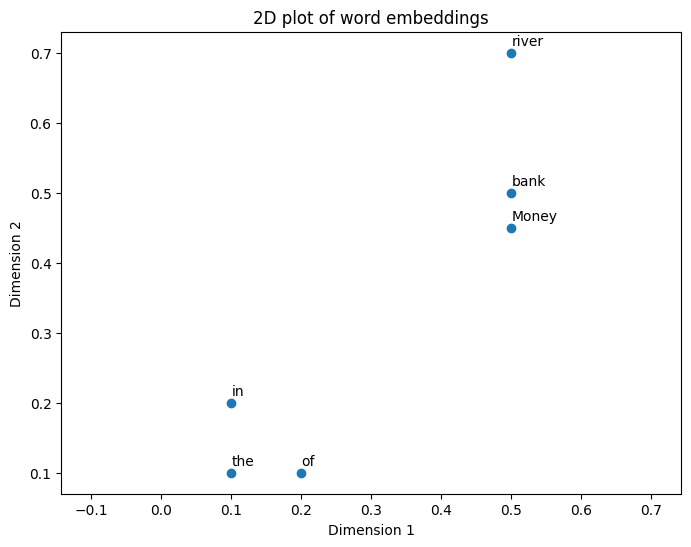

In [2]:
import matplotlib.pyplot as plt

# Extract the coordinates for 2D plotting
x_2d_adj = [embeddings[word][0] for word in embeddings]
y_2d_adj = [embeddings[word][1] for word in embeddings]
words_2d_adj = list(embeddings.keys())

# Create a 2D plot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter the points
ax.scatter(x_2d_adj, y_2d_adj)

# Annotate the points with words
for i, word in enumerate(words_2d_adj):
    ax.text(x_2d_adj[i], y_2d_adj[i] + 0.01, word)  # Adjust text position for clarity

# Set labels
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('2D plot of word embeddings')

# Set equal scaling
ax.axis('equal')

# Show the plot
plt.show()


In [3]:
# Sentence 1
sentence_1 = ["the", "bank", "of", "the", "river"]

# Initialize matrices for Q, K, V
Q_1 = np.array([embeddings[word] for word in sentence_1])
K_1 = np.array([embeddings[word] for word in sentence_1])
V_1 = np.array([embeddings[word] for word in sentence_1])

# Step 1: Similarity - Calculate dot products for Q and K (attention scores)
attention_scores_1 = Q_1.dot(K_1.T)

# Step 2: Weights - Apply softmax to attention scores
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

attention_weights_1 = np.apply_along_axis(softmax, 1, attention_scores_1)

# Step 3: Contextualized vector - Multiply attention weights by V and sum to get output vectors
attention_output_1 = attention_weights_1.dot(V_1)

In [4]:
attention_scores_1

array([[0.02, 0.1 , 0.03, 0.02, 0.12],
       [0.1 , 0.5 , 0.15, 0.1 , 0.6 ],
       [0.03, 0.15, 0.05, 0.03, 0.17],
       [0.02, 0.1 , 0.03, 0.02, 0.12],
       [0.12, 0.6 , 0.17, 0.12, 0.74]])

In [5]:
attention_weights_1

array([[0.19236288, 0.20838422, 0.19429616, 0.19236288, 0.21259386],
       [0.16150348, 0.24093488, 0.16978394, 0.16150348, 0.26627422],
       [0.18875147, 0.21281669, 0.1925645 , 0.18875147, 0.21711587],
       [0.19236288, 0.20838422, 0.19429616, 0.19236288, 0.21259386],
       [0.1532268 , 0.24762591, 0.1610829 , 0.1532268 , 0.28483759]])

In [6]:
attention_output_1

array([[0.28782085, 0.31091   ],
       [0.31986203, 0.35613848],
       [0.29122947, 0.3153962 ],
       [0.28782085, 0.31091   ],
       [0.32909369, 0.36995292]])

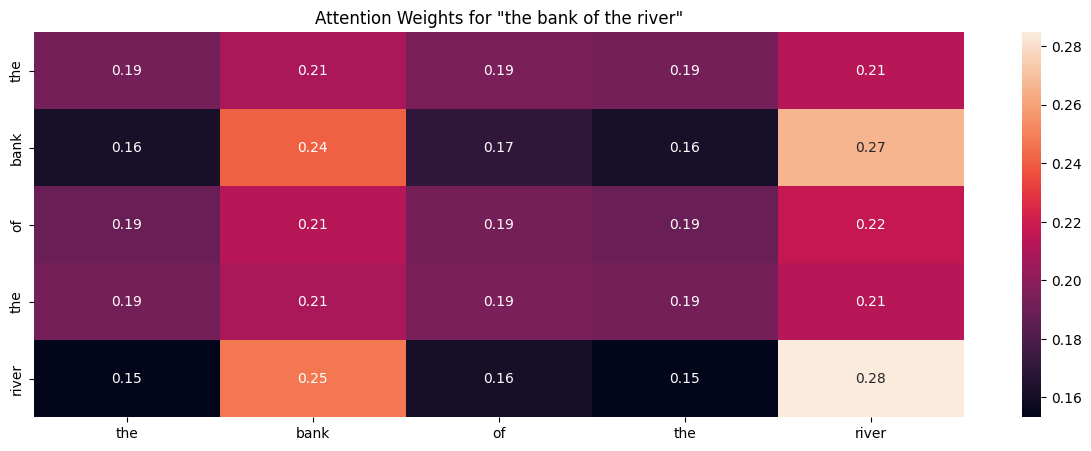

In [7]:
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Sentence 1: "the bank of the river"
# Create a heatmap for the attention weights of the first sentence
sns.heatmap(attention_weights_1, annot=True, fmt=".2f", xticklabels=sentence_1, yticklabels=sentence_1)
axes.set_title('Attention Weights for "the bank of the river"')

plt.show()

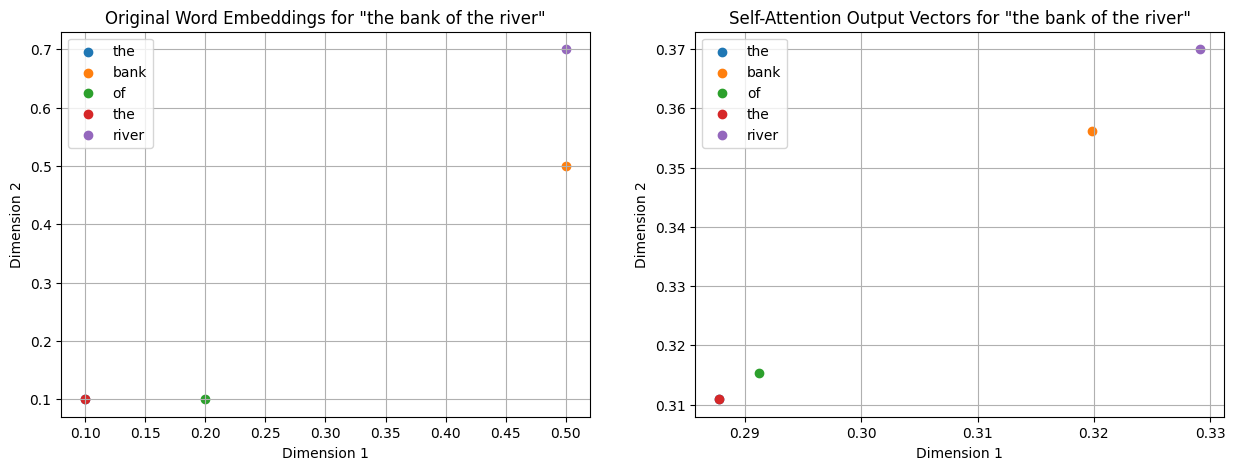

In [ ]:
# Plotting the original embeddings and the attention output for the first sentence "the bank of the river"

# Extract the relevant embeddings for the first sentence
sentence_embeddings_1 = np.array([embeddings[word] for word in sentence_1])

# Convert the attention output for the first sentence to a numpy array for ease of use
attention_output_array_1 = np.array(attention_output_1)

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot original embeddings
for i, word in enumerate(sentence_1):
    axes[0].scatter(sentence_embeddings_1[i, 0], sentence_embeddings_1[i, 1], label=f"{word}")

axes[0].set_title('Original Word Embeddings for "the bank of the river"')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].grid(True)
axes[0].legend()

# Plot output vectors
for i, word in enumerate(sentence_1):
    axes[1].scatter(attention_output_array_1[i, 0], attention_output_array_1[i, 1], label=f"{word}")

axes[1].set_title('Self-Attention Output Vectors for "the bank of the river"')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].grid(True)
axes[1].legend()

plt.show()


In [ ]:
# Calculate the Euclidean distance between "Money" and "bank" in the original embeddings for the second sentence
original_river = embeddings["river"]
original_bank = embeddings["bank"]  # The same embedding for "bank" is used as in the first sentence
distance_original = np.linalg.norm(original_river - original_bank)

# Find the positions of "Money" and "bank" in the second sentence
river_position = sentence_1.index("river")
bank_position = sentence_1.index("bank")

# Calculate the Euclidean distance between "Money" and "bank" in the output vectors for the second sentence
output_river = attention_output_1[river_position]
output_bank = attention_output_1[bank_position]
distance_output = np.linalg.norm(output_river - output_bank)

distance_original, distance_output


(0.19999999999999996, 0.016615114409190702)

# Exercise 1

Calculate contextualized vectors for "Money in the bank" using the self-attention mechanism?



In [ ]:
# Second example sentence
sentence_2 = ["Money", "in", "the", "bank"]

# Initialize matrices for Q, K, V for the second sentence


# Step 1: Similarity - Calculate dot products for Q and K (attention scores)

# Step 2: Weights - Apply softmax to attention scores

# Step 3: Contextualized vector - Multiply attention weights by V and sum to get output vectors for the second sentence


In [ ]:
attention_weights_2

array([[0.28953672, 0.21182959, 0.20250855, 0.29612514],
       [0.26179275, 0.23926056, 0.23452288, 0.26442381],
       [0.25840972, 0.24214734, 0.23973793, 0.259705  ],
       [0.29110965, 0.21033468, 0.20007654, 0.29847913]])

In [ ]:
attention_output_2

array([[0.33426474, 0.34097087],
       [0.31048662, 0.32132304],
       [0.30724589, 0.31854014],
       [0.33583551, 0.3423135 ]])

In [ ]:
# Calculate the Euclidean distance between "Money" and "bank" in the original embeddings for the second sentence


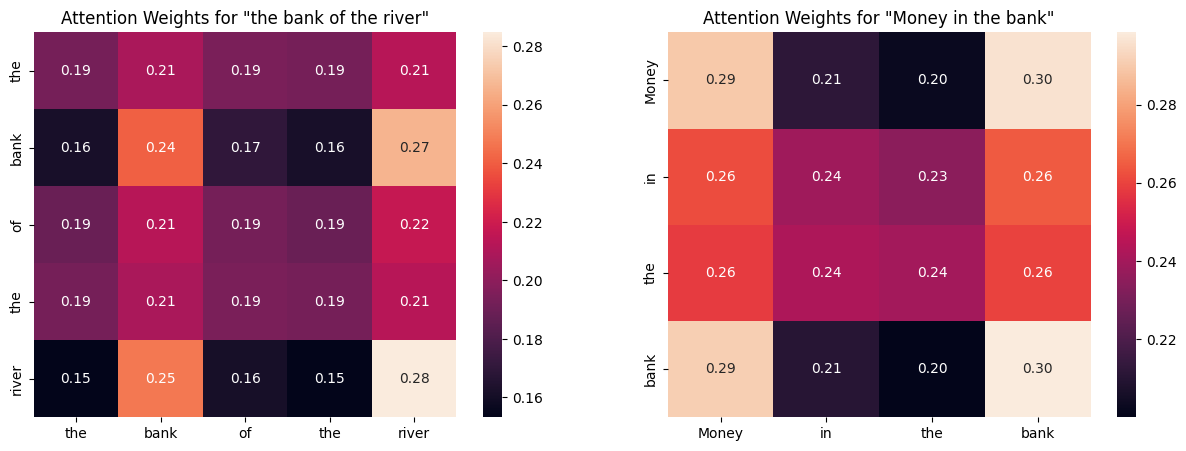

In [ ]:
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sentence 1: "the bank of the river"
# Create a heatmap for the attention weights of the first sentence
sns.heatmap(attention_weights_1, annot=True, fmt=".2f", xticklabels=sentence_1, yticklabels=sentence_1, ax=axes[0])
axes[0].set_title('Attention Weights for "the bank of the river"')

# Sentence 2: "Money in the bank"
# Create a heatmap for the attention weights of the second sentence
sns.heatmap(attention_weights_2, annot=True, fmt=".2f", xticklabels=sentence_2, yticklabels=sentence_2, ax=axes[1])
axes[1].set_title('Attention Weights for "Money in the bank"')

plt.show()

# Transformer Model Architecture

![](https://lilianweng.github.io/posts/2018-06-24-attention/transformer.png)

| Model           | Examples                                 | Tasks                                               |
|-----------------|------------------------------------------|-----------------------------------------------------|
| Encoder         | ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa | Sentence classification, named entity recognition, extractive question answering |
| Decoder         | CTRL, GPT, GPT-2, Transformer XL         | Text generation                                     |
| Encoder-decoder | BART, T5, Marian, mBART                  | Summarization, translation, generative question answering |


In [ ]:
# Residual connection
residual_2 = Q_2 + attention_output_2

In [ ]:
# Layer normalization
norm_layer = torch.nn.LayerNorm(2)
norm_layer(torch.tensor(residual_2, dtype=torch.float32))

tensor([[ 0.9895, -0.9895],
        [-0.9984,  0.9984],
        [-0.8725,  0.8725],
        [-0.7155,  0.7155]], grad_fn=<NativeLayerNormBackward0>)

# What is text embedding?

Text embedding is a representation of text in the form of vectors. The main goal of embedding is to capture the semantic meaning of the text in a way that reflects the context and usage of words or phrases. In machine learning, embeddings are used to convert text into a continuous vector space where similar words have similar representations, making it easier for models to understand and process language.

![](https://www.researchgate.net/publication/340825443/figure/fig6/AS:882927785238529@1587517796128/Word-embeddings-map-words-in-a-corpus-of-text-to-vector-space-Linear-combinations-of.png)

Let's try checking the embeddings of words.


[Embeddings Projector](https://projector.tensorflow.org/)

In general all types of text embeddings approaches can be grouped into two categorizes namely word enbeddings and sentence embeddings.

![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/word_embeddings.png)

In the first step, we will explore BERT models. Afterward, we will investigate the SBERT approach to generating sentence embeddings.



![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/sentence_embeddings.png)

# How can trian a transformer model to compute embeddings?

There are two different types of training for Transformer models: **pre-training** and **fine-tuning**.


![](https://docs.graphcore.ai/projects/bert-training/en/latest/_images/training-tuning-inference.png)

For Transformer models that use a **Masked Language Model (MLM)** approach, such as BERT, the training process is specialized to handle the unique challenges of understanding language in a bidirectional context. Here's an overview of the training approaches for MLM-based Transformer models:

## Pre-training

MLM-based models are typically trained in two stages, with pre-training being the first:

> - **Masked Language Modeling**: In this core pre-training task, a certain percentage of the input tokens are replaced with a [MASK] token, and the model must predict the original token. This trains the model to understand context and to use surrounding words to fill in blanks. For example:
      Original Sentence: "The quick brown fox jumps over the lazy dog."
      MLM Input: "The quick brown [MASK] jumps over the lazy dog."
      Model's Task: Predict the word "fox" to replace [MASK].
> - **Next Sentence Prediction (NSP)**: In the case of BERT, along with the MLM task, the model is also trained on a binary classification task to predict whether two sentences follow each other in the original text. This helps the model learn relationships between sentences. For example:
      Sentence A: "The quick brown fox jumps over the lazy dog."
      Sentence B: "It then swiftly ran up the hill."
      Sentence B: "Oranges are rich in vitamin C."

During pre-training, the model is trained on a large, diverse corpus of text to develop a broad understanding of language. The choice of corpus is crucial — it needs to be large and varied enough to ensure that the model can learn a wide range of linguistic patterns and structures.

## Fine-tuning

Once pre-trained, the model can be fine-tuned on specific downstream tasks:

> - **Supervised Fine-tuning**: Here, the pre-trained model is fine-tuned on a smaller, labeled dataset for tasks such as sentiment analysis, named entity recognition, or question answering. The fine-tuning adapts the model to the specificities of the task at hand.
> - **Task-specific Inputs**: For fine-tuning, the input format is often adapted to the specific task. For instance, for question answering, the input may be structured as "[QUESTION] [SEP] [CONTEXT]" where [SEP] is a special token that separates the question from the context passage.
> - **Output Layer**: During fine-tuning, a task-specific output layer is often added on top of the pre-trained model. For example, for classification tasks, a softmax layer is added to output probability distributions over classes.

### Let's check the architecture of BERT!

![](https://vitalflux.com/wp-content/uploads/2023/08/BERT-base-BERT-Large-neural-network-architectures.png)

### Let's see how BERT has been trianed!

![](https://360digit.b-cdn.net/assets/admin/ckfinder/userfiles/images/blog/11-05-2021/11-05-2021(a)/image4.jpg)

In [ ]:
!pip install transformers --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.6 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertModel

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the sentence
sentence = "The bank of the river."
inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)

# Get the token IDs (input to the model)
input_ids = inputs['input_ids']

# Forward pass through BERT to get the embeddings
with torch.no_grad():
    outputs = model(input_ids)

# The last_hidden_state is the embeddings for the last layer
# It has shape [batch_size, sequence_length, hidden_size], where hidden_size is 768 for BERT base
embeddings = outputs.last_hidden_state.squeeze(0)  # Remove the batch dimension

# Now, `embeddings` contains the embeddings for each token in the sentence


In [ ]:
embeddings.shape

torch.Size([8, 768])

Remember that BERT adds special tokens like [CLS] at the start and [SEP] at the end of the sentence. If you're interested in word-level embeddings, you would ignore these special tokens.

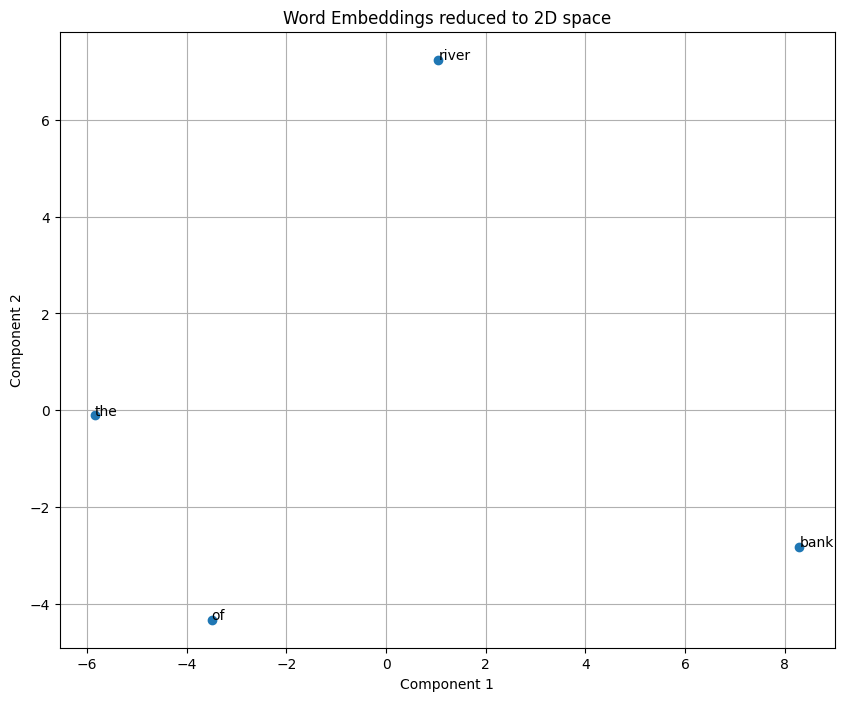

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a PCA object to reduce to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings using PCA
reduced_embeddings = pca.fit_transform(embeddings[2:6])

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

# Annotate the points with the words
words = ["bank", "of", "the", "river"]

for i, word in enumerate(words):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('Word Embeddings reduced to 2D space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


![](https://media.arxiv-vanity.com/render-output/7086622/bert_pretraining.png)

In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

> **nn.Embedding** in PyTorch is like a large lookup table that maps each unique word or token in your vocabulary to a high-dimensional vector. Imagine it as a dictionary, but instead of giving you the definition of a word, it gives you a list of numbers that represent that word in a space where similar words are closer together.

In [ ]:
import torch
import torch.nn as nn

# Step 1: Create a vocabulary. Normally you'd want a large corpus to create this.
vocab = {'<pad>': 0, 'The': 1, 'bank': 2, 'of': 3, 'river': 4}
vocab_size = len(vocab)  # This will be the number of rows in the embedding matrix.
embedding_dim = 2  # You can choose the size of the embeddings.

# Step 2: Convert the sentence "The bank of river" to indices.
sentence = "The bank of river"
indices = [vocab[word] for word in sentence.split()]

# Step 3: Create the embedding layer.
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# Step 4: Use the embedding layer to get embeddings for the indices.
# Convert indices list to a tensor.
indices_tensor = torch.LongTensor(indices)

# Get embeddings for indices.
embeddings = embedding_layer(indices_tensor)

print(embeddings)  # This will print out the embeddings for each word in the sentence.

tensor([[ 6.1823e-01,  3.7927e-02],
        [-2.4960e-03, -3.9648e-01],
        [-1.2649e+00, -2.9598e+00],
        [-3.8356e-01,  1.8303e+00]], grad_fn=<EmbeddingBackward0>)


In [ ]:
embeddings.shape

torch.Size([4, 2])

# Exercise 2

Calculate embeddings for "Money in the bank" using BERT, and show the embeddings for each word?



To begin with, it's essential to grasp the distinctions between Bi-Encoders and Cross-Encoders.

- Bi-Encoders generate a sentence embedding for a specific sentence. In this process, sentences A and B are independently fed into a BERT model, resulting in sentence embeddings u and v, respectively. These embeddings can then be evaluated against each other using cosine similarity.

- Cross-Encoders take both sentences at the same time and input them into the Transformer model. This model then yields a score ranging from 0 to 1 that reflects the degree of similarity between the two input sentences.


![](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

Unlike Bi-Encoders, Cross-Encoders do not create sentence embeddings. Additionally, it's not possible to input sentences into a Cross-Encoder one at a time.

In [ ]:
!pip install -U sentence-transformers --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.1 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences, convert_to_tensor=True)

#Print the embeddings
for sentence, embedding in zip(sentences[:1], embeddings[:1]):
    print("Sentence:", sentence)
    print("Embedding shape:", embedding.shape)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding shape: torch.Size([384])



# Exercise 3

Calculate embeddings for "The bank of the river" and "Money in the bank" using SBERT, and show the embeddings for each sentence?

In [ ]:
sentence_1 = 'The bank of the river'
sentence_2 = 'Money in the bank'

# Tokenizers (PyTorch)

In [ ]:
tokenized_text = "The bank of the river".split()
print(tokenized_text)

['The', 'bank', 'of', 'the', 'river']


In [ ]:
tokenizer("The bank of the river")

{'input_ids': [101, 1996, 2924, 1997, 1996, 2314, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.save_pretrained("directory_on_my_computer")

('directory_on_my_computer/tokenizer_config.json',
 'directory_on_my_computer/special_tokens_map.json',
 'directory_on_my_computer/vocab.txt',
 'directory_on_my_computer/added_tokens.json')

In [ ]:
sentence_1 = "The bank of the river."
tokens = tokenizer.tokenize(sentence_1)

print(tokens)

['the', 'bank', 'of', 'the', 'river', '.']


In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[1996, 2924, 1997, 1996, 2314, 1012]


In [ ]:
decoded_string = tokenizer.decode([1996, 2924, 1997, 1996, 2314, 1012])
print(decoded_string)

the bank of the river.


In [ ]:
len(tokenizer.vocab)

30522

# Architectures vs. Checkpoints

As we dive into Transformer models in this course, you’ll see mentions of architectures and checkpoints as well as models. These terms all have slightly different meanings:

- Architecture: This is the skeleton of the model — the definition of each layer and each operation that happens within the model.
- Checkpoints: These are the weights that will be loaded in a given architecture.
- Model: This is an umbrella term that isn’t as precise as “architecture” or “checkpoint”: it can mean both. This course will specify architecture or checkpoint when it matters to reduce ambiguity.

For example, BERT is an architecture while bert-base-cased, a set of weights trained by the Google team for the first release of BERT, is a checkpoint. However, one can say “the BERT model” and “the bert-base-cased model.”

![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/transformermodel_architecture.png)